# The Titanic Dataset
#### The task is to use the Titanic dataset to build a classifier that can predict whether someone survived the Titanic crash given some attributes.

### Obtaining the dataset

In [ ]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_stdlib_context

In [ ]:
def load_titanic_data(train_or_test):
    '''
    Returns a pandas dataframe containing the Titanic data
    '''
    tarball_path = Path("datasets/titanic.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://homl.info/titanic.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as titanic_tarball:
            titanic_tarball.extractall(path="datasets")
    return pd.read_csv(Path(f"datasets/titanic/{train_or_test}.csv"))

### Separating into Train and Test Set
### Along with some Exploratory Data Analysis (EDA)

In [ ]:
X_train = load_titanic_data("train")

In [ ]:
print(f"The shape of the training data: {X_train.shape}.")

The shape of the training data: (891, 12).


In [ ]:
X_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


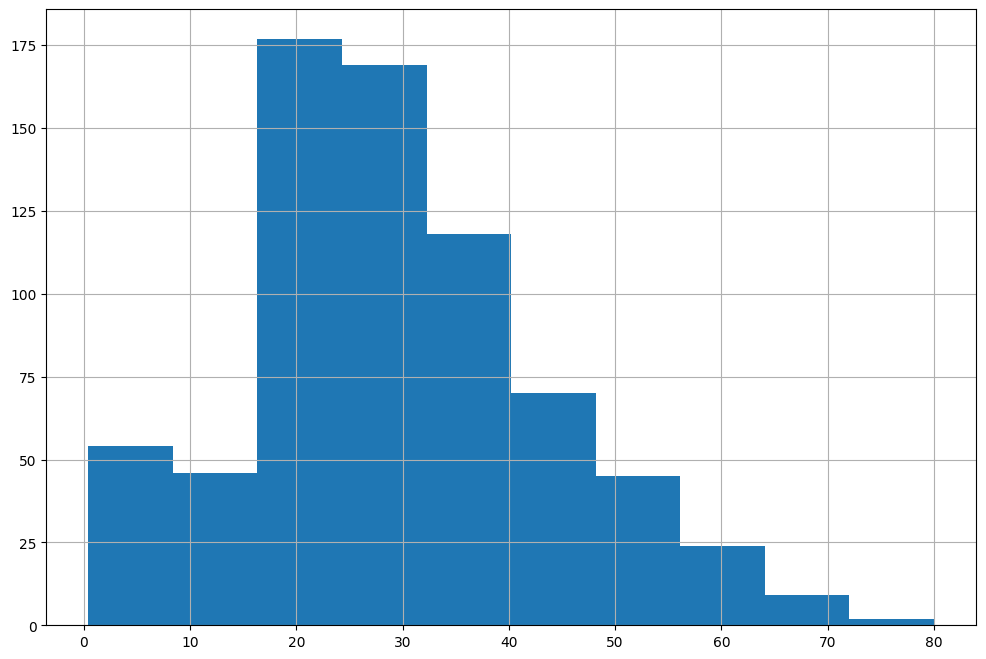

In [ ]:
import matplotlib.pyplot as plt

X_train["Age"].hist(bins=10, figsize=(12, 8))
plt.show()

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


- Since we notice that there are missing age values, let us impute. 
- I want to use the median age for passengers of that Pclass and Gender.
- e.g. if there is no age for a female in first class, I will set her age to be the median of all females in first class. 

In [ ]:
# Calculate the median age by each Pclass-gender group
df_median_age = X_train.groupby(["Sex", "Pclass"])["Age"].median().reset_index()
df_median_age = df_median_age.rename(columns={"Age" : "median_age"})
print(df_median_age)

      Sex  Pclass  median_age
0  female       1        35.0
1  female       2        28.0
2  female       3        21.5
3    male       1        40.0
4    male       2        30.0
5    male       3        25.0


In [ ]:
# Next we want to merge the median ages as a new column into the original dataframe
X_train = pd.merge(X_train, df_median_age, on=["Sex", "Pclass"], how="left")
X_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,median_age
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,25.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,35.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,21.5
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,35.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,25.0


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  median_age   891 non-null    float64
dtypes: float64(3), int64(5), object(5)
memory usage: 90.6+ KB


In [ ]:
# Finally, we replace any null ages with the median age and then drop the median_age column
X_train["Age"] = X_train.apply(
    lambda row: row["median_age"] if pd.isnull(row["Age"]) else row["Age"], axis=1
)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  median_age   891 non-null    float64
dtypes: float64(3), int64(5), object(5)
memory usage: 90.6+ KB


In [ ]:
X_train = X_train.drop(columns=["median_age"])

In [ ]:
# Copy for experimentation
df_titanic = X_train.copy()

In [ ]:
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
# Drop the two rows where Embarked is null
df_titanic = df_titanic.dropna(subset=["Embarked"])

In [ ]:
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Cabin        202 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 90.3+ KB


In [ ]:
# Next I want to remove the Cabin, PassengerId, and Name columns altogether
df_titanic = df_titanic.drop(columns=["PassengerId", "Name", "Cabin"])

In [ ]:
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Sex       889 non-null    object 
 3   Age       889 non-null    float64
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    int64  
 6   Ticket    889 non-null    object 
 7   Fare      889 non-null    float64
 8   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 69.5+ KB


In [ ]:
df_titanic_numeric_attrs = ["Pclass", "Age", "SibSp", "Parch", "Fare", "Survived"]
corr_matrix = df_titanic[df_titanic_numeric_attrs].corr()
corr_matrix["Survived"].sort_values(ascending=False)


Survived    1.000000
Fare        0.255290
Parch       0.083151
SibSp      -0.034040
Age        -0.064411
Pclass     -0.335549
Name: Survived, dtype: float64

- Of these attributes, the fare paid and the class of the ticket seem to be the strongest indicators of survival.

#### Handling Categorical Attributes

In [ ]:
df_titanic["Embarked"].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [ ]:
df_titanic_cat = df_titanic[["Pclass", "Sex", "Embarked"]]

In [ ]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder()
one_hot_encoder.handle_unknown = "ignore"
cat_1hot_matrix = one_hot_encoder.fit_transform(df_titanic_cat)

In [ ]:
one_hot_encoder.categories_

[array([1, 2, 3]),
 array(['female', 'male'], dtype=object),
 array(['C', 'Q', 'S'], dtype=object)]

In [ ]:
# Creating a dataframe using the new one hot columns
print(one_hot_encoder.get_feature_names_out())

df_titanic_cat_1hot = pd.DataFrame(
    one_hot_encoder.transform(df_titanic_cat).toarray(),
    columns=one_hot_encoder.get_feature_names_out(),
    index=df_titanic_cat.index
)

['Pclass_1' 'Pclass_2' 'Pclass_3' 'Sex_female' 'Sex_male' 'Embarked_C'
 'Embarked_Q' 'Embarked_S']


In [ ]:
df_titanic_cat_1hot.head()

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [ ]:
df_titanic_cat_1hot.columns

Index(['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [ ]:
print(f"Length of the numeric dataset: {len(df_titanic[df_titanic_numeric_attrs])}")
print(f"Length of the categorical dataset: {len(df_titanic_cat_1hot)}")

Length of the numeric dataset: 889
Length of the categorical dataset: 889


In [ ]:
df_titanic_full_1hot = df_titanic[df_titanic_numeric_attrs].join(df_titanic_cat_1hot)
df_titanic_full_1hot.head()

,Pclass,Age,SibSp,Parch,Fare,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,1,38.0,1,0,71.2833,1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,3,26.0,0,0,7.9250,1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,1,35.0,1,0,53.1000,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,3,35.0,0,0,8.0500,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [ ]:
df_titanic_full_1hot.columns

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Survived', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_C',
       'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [ ]:
df_titanic_full_1hot = df_titanic_full_1hot.drop(columns=["Pclass"])

In [ ]:
df_titanic_full_1hot.columns

Index(['Age', 'SibSp', 'Parch', 'Fare', 'Survived', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q',
       'Embarked_S'],
      dtype='object')

#### Training Data Summary
- A large percentage of passengers are between 20 and 30
- There are 577 males and 314 females
- The majority of tickets are 3rd class tickets
- So when splitting the data into training and validation, we may want to stratify on the these 3 categories. We can combine them to create the classes:
    - `male_child_c1` : a male below the age of 18 with a first class ticket
    - `male_youngAdult_c1` : a male between 18 and 35 (inclusive) with a first class ticket
    - `male_adult_c1` : a male between over 35 with a first class ticket

    - `male_child_c2` : a male below the age of 18 with a second class ticket
    - `male_youngAdult_c2` : a male between 18 and 35 (inclusive) with a second class ticket
    - `male_adult_c2` : a male between over 35 with a second class ticket

    - `male_child_c3` : a male below the age of 18 with a third class ticket
    - `male_youngAdult_c3` : a male between 18 and 35 (inclusive) with a third class ticket
    - `male_adult_c3` : a male between over 35 with a third class ticket

    - `female_child_c1` : a female below the age of 18 with a first class ticket
    - `female_youngAdult_c1` : a female between 18 and 35 (inclusive) with a first class ticket
    - `female_adult_c1` : a female between over 35 with a first class ticket

    - `female_child_c2` : a female below the age of 18 with a second class ticket
    - `female_youngAdult_c2` : a female between 18 and 35 (inclusive) with a second class ticket
    - `female_adult_c2` : a female between over 35 with a second class ticket
    
    - `female_child_c3` : a female below the age of 18 with a third class ticket
    - `female_youngAdult_c3` : a female between 18 and 35 (inclusive) with a third class ticket
    - `female_adult_c3` : a female between over 35 with a third class ticket

In [ ]:
import numpy as np

passenger_categorizations = []
for i in range(len(df_titanic_full_1hot)):

    curr_sex_fem = df_titanic_full_1hot.iloc[i]["Sex_female"]
    curr_sex_male = df_titanic_full_1hot.iloc[i]["Sex_male"]

    curr_age = df_titanic_full_1hot.iloc[i]["Age"] 
    
    curr_class_1 = df_titanic_full_1hot.iloc[i]["Pclass_1"]
    curr_class_2 = df_titanic_full_1hot.iloc[i]["Pclass_2"]
    curr_class_3 = df_titanic_full_1hot.iloc[i]["Pclass_3"]

    if curr_age < 18:
        age_cat = "child"
    elif curr_age > 35:
        age_cat = "adult"
    elif curr_age >= 18 and curr_age <=35:
        age_cat = "youngAdult"
    else:
        age_cat = "NaN"

    if curr_class_1 == 1:
        class_cat = "c1"
    elif curr_class_2 == 1:
        class_cat = "c2"
    else:
        class_cat = "c3"
    
    if curr_sex_fem == 1:
        sex_cat = "female"
    else:
        sex_cat = "male"
    
    passenger_categorizations.append(sex_cat + "_" + age_cat + "_" + class_cat)

df_titanic_full_1hot["passenger_categorization"] = passenger_categorizations

In [ ]:
df_titanic_full_1hot[[
    "Sex_female", "Sex_male",
    "Age", "Pclass_1", "Pclass_2", "Pclass_3", "passenger_categorization"
]]

,Sex_female,Sex_male,Age,Pclass_1,Pclass_2,Pclass_3,passenger_categorization
0,0.0,1.0,22.0,0.0,0.0,1.0,male_youngAdult_c3
1,1.0,0.0,38.0,1.0,0.0,0.0,female_adult_c1
2,1.0,0.0,26.0,0.0,0.0,1.0,female_youngAdult_c3
3,1.0,0.0,35.0,1.0,0.0,0.0,female_youngAdult_c1
4,0.0,1.0,35.0,0.0,0.0,1.0,male_youngAdult_c3
...,...,...,...,...,...,...,...
886,0.0,1.0,27.0,0.0,1.0,0.0,male_youngAdult_c2
887,1.0,0.0,19.0,1.0,0.0,0.0,female_youngAdult_c1
888,1.0,0.0,21.5,0.0,0.0,1.0,female_youngAdult_c3
889,0.0,1.0,26.0,1.0,0.0,0.0,male_youngAdult_c1


In [ ]:
df_titanic_full_1hot["passenger_categorization"].value_counts()

passenger_categorization
male_youngAdult_c3      256
female_youngAdult_c3     94
male_adult_c1            87
male_youngAdult_c2       67
female_youngAdult_c1     48
male_adult_c3            48
female_youngAdult_c2     44
male_child_c3            43
female_adult_c1          36
female_child_c3          35
male_youngAdult_c1       31
male_adult_c2            30
female_adult_c2          20
female_adult_c3          15
female_child_c2          12
male_child_c2            11
female_child_c1           8
male_child_c1             4
Name: count, dtype: int64

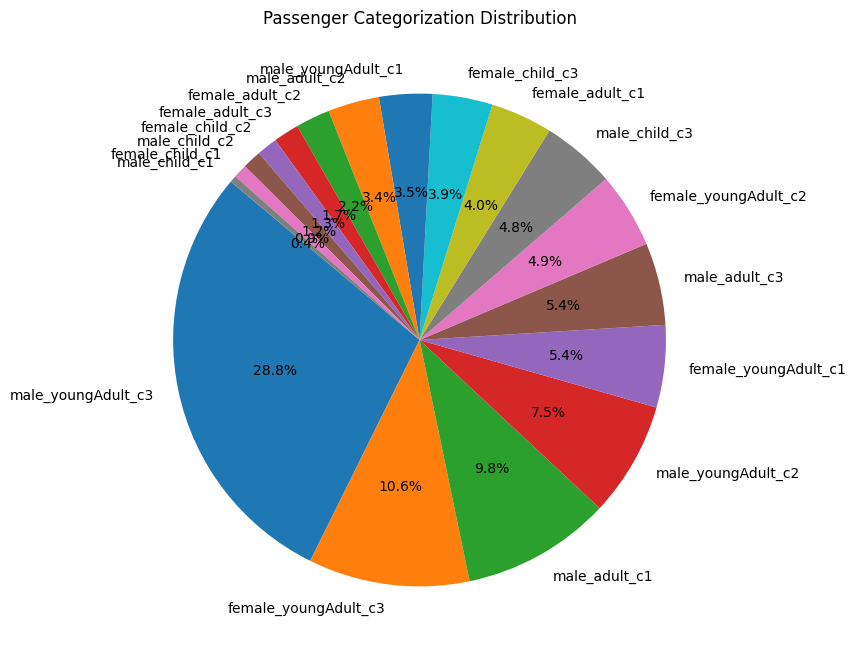

In [ ]:
category_counts = df_titanic_full_1hot['passenger_categorization'].value_counts() 

# Create a pie chart 
plt.figure(figsize=(12, 8)) 
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140) 
plt.title('Passenger Categorization Distribution')
plt.show()

- From the above chart, we can see that male passengers between the ages of 18 and 35 with the  are the most common.
- Interestingly, first class males above 35 are the third most common.
- We will now create our stratified validation set based on this.

In [ ]:
from sklearn.model_selection import train_test_split

df_strat_train_set, df_strat_val_set = train_test_split(
    df_titanic_full_1hot, test_size=0.2, stratify=df_titanic_full_1hot["passenger_categorization"], 
    random_state=42
)

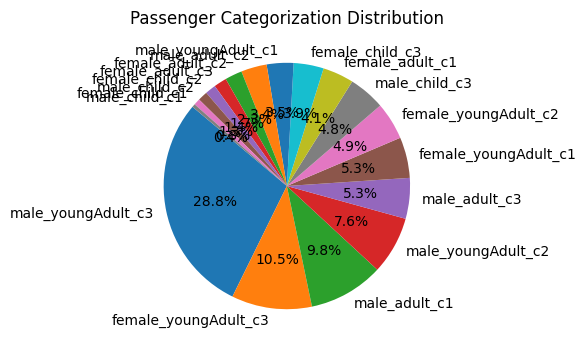

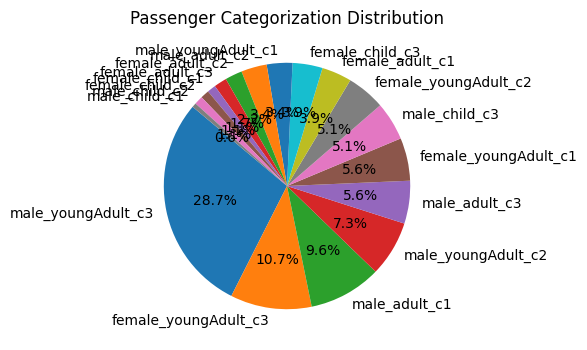

In [ ]:
# Checking to make sure the new train and test sets have roughly the same category distribution
category_counts = df_strat_train_set['passenger_categorization'].value_counts() 

# Create a pie chart 
plt.figure(figsize=(6, 4)) 
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140) 
plt.title('Passenger Categorization Distribution')
plt.show()

category_counts = df_strat_val_set['passenger_categorization'].value_counts() 

# Create a pie chart 
plt.figure(figsize=(6, 4)) 
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140) 
plt.title('Passenger Categorization Distribution')
plt.show()

In [ ]:
for df in (df_strat_train_set, df_strat_val_set):
    df.drop("passenger_categorization", axis=1, inplace=True)

Great, now we can delete the column we created for stratifying!

In [ ]:
df_strat_train_set.columns

Index(['Age', 'SibSp', 'Parch', 'Fare', 'Survived', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q',
       'Embarked_S'],
      dtype='object')

In [ ]:
# Now we want to separate the labels
df_strat_train_labels = df_strat_train_set[["Survived"]]
df_strat_train_set = df_strat_train_set.drop(columns=["Survived"])

df_strat_val_labels = df_strat_val_set[["Survived"]]
df_strat_val_set = df_strat_val_set.drop(columns=["Survived"])

In [ ]:
print(f"Shape of the stratified training set: {df_strat_train_set.shape} and labels: {df_strat_train_labels.shape}")
print(f"Shape of the stratified test set: {df_strat_val_set.shape} and labels: {df_strat_val_labels.shape}")

Shape of the stratified training set: (711, 12) and labels: (711, 1)
Shape of the stratified test set: (178, 12) and labels: (178, 1)


In [ ]:
# This is the final test set which is used to simulate real-world instances of the data
X_test = load_titanic_data("test")
print(X_test.columns)

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


### Training Some Models

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(df_strat_train_set, df_strat_train_labels)

/Users/tevinachong/Documents/Courses/hands-on-ml/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDClassifier(random_state=42)

In [ ]:
rand_idx = 200
print(df_strat_train_set.iloc[rand_idx])
print(df_strat_train_labels.iloc[rand_idx])

Age           21.5000
SibSp          0.0000
Parch          0.0000
Fare           7.7875
Pclass_1       0.0000
Pclass_2       0.0000
Pclass_3       1.0000
Sex_female     1.0000
Sex_male       0.0000
Embarked_C     0.0000
Embarked_Q     1.0000
Embarked_S     0.0000
Name: 82, dtype: float64

In [ ]:

# Testing if the model can correctly predict a random passenger's survival
print(f"The model predicted that the random passenger\
 {'SURVIVED' if sgd_clf.predict([df_strat_train_set.iloc[rand_idx]]) == False else 'DID NOT SURVIVE'}")

print(f"The random passenger actually \
 {'SURVIVED' if sgd_clf.predict(df_strat_train_labels.iloc[rand_idx]) == False else 'DID NOT SURVIVE'}")

The model predicted that the random passenger  DID NOT SURVIVE


/Users/tevinachong/Documents/Courses/hands-on-ml/venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
/Users/tevinachong/Documents/Courses/hands-on-ml/venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


ValueError: Expected a 2-dimensional container but got <class 'pandas.core.series.Series'> instead. Pass a DataFrame containing a single row (i.e. single sample) or a single column (i.e. single feature) instead.